# INIT

In [1]:
## For google colab only
from google.colab import drive
drive.mount('/content/drive')
import sys, os
## on Phuc's drive
%cd /content/drive/MyDrive/Uni/Thesis/Repo 
os.chdir("/content/drive/MyDrive/Uni/Thesis/Repo")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Uni/Thesis/Repo


In [2]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.5 MB/s 
time: 502 µs (started: 2022-11-26 16:18:05 +00:00)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
import sys, os, json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

""" PY FILES """
py_file_location = "/content/drive/MyDrive/Uni/Thesis/Repo/utils"
sys.path.append(os.path.abspath(py_file_location))


time: 5.35 s (started: 2022-11-26 16:18:05 +00:00)


In [4]:
!pwd

/content/drive/MyDrive/Uni/Thesis/Repo
time: 135 ms (started: 2022-11-26 16:18:11 +00:00)


In [5]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.3 MB/s eta 0:12:44tcmalloc: large alloc 1147494400 bytes == 0x65e7a000 @  0x7fba1124f615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 1.8 MB/s 
     |████████████████████████████████| 237 kB 9.5 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 13.4 MB/s 
     |████████████████████████████████| 190 kB 4.5 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12481, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 12481 (delta 61), reused 83 (delta 41), pack-reused 12359
Receiving objects: 100% (12481/12481), 15.00 MiB | 9.31 MiB/s, done.
Resolving deltas: 100% (9032/9032), done.
Checking out files: 100% (1238/1238), done.
/content/drive/MyDrive/Uni/The

In [6]:
from parse_dataset import *
from eval import *
from image_extract import *

load checkpoint from local path: /content/drive/MyDrive/Uni/Thesis/Repo/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
time: 15 s (started: 2022-11-26 16:22:34 +00:00)


In [7]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
# config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
# checkpoint_file = '../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/drive/MyDrive/Uni/Thesis/Repo/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
time: 1.55 s (started: 2022-11-26 16:22:50 +00:00)


## Json file reading

In [11]:
detectDS_link = '/content/drive/MyDrive/Uni/Thesis/dataset/detection'
# classifyDS_link = '/content/drive/MyDrive/Uni/Thesis/dataset/classification'
# In detection folder
dtecDS_info = "/content/drive/MyDrive/Uni/Thesis/dataset/detection/PasadenaUrbanTrees/detection_datasets.json"
#clsDS_info = "/content/drive/MyDrive/Uni/Thesis/dataset/detection/PasadenaUrbanTrees/classification_datasets.json"
rois_info =  "/content/drive/MyDrive/Uni/Thesis/dataset/detection/PasadenaUrbanTrees/rois.json"
pano_info = "/content/drive/MyDrive/Uni/Thesis/dataset/detection/PasadenaUrbanTrees/panos.json"

time: 1.02 ms (started: 2022-11-26 16:24:45 +00:00)


In [12]:
""" TREE DF """

with open(dtecDS_info) as json_data:
  data = json.load(json_data)

def getDtecDFInfo(ds):
    dsX = pd.DataFrame(list(ds['extended']))
    df = pd.concat([ds,dsX], axis=1)
    # df = df.drop(['Longitude','Latitude','extended'], axis=1)

    return df
dtecDF_Itrain, dtecDF_Itest, dtecDF_Ival = [getDtecDFInfo(pd.DataFrame(data[x])) for x in ('train', 'test', 'val')]
# dtecDF_Itrain = dtecDF_Itrain.drop(['Street_Type','Common_Name','Genus','Species','Street_Suffix','Longitude','Latitude','extended'], axis=1)

time: 501 ms (started: 2022-11-26 16:24:45 +00:00)


In [13]:
""" 
ROI json
"""
with open(rois_info) as json_data:
  roiData = json.load(json_data)

roiDF = pd.DataFrame(roiData)

time: 8.12 ms (started: 2022-11-26 16:24:46 +00:00)


# Parse dataset

In [14]:
## Using helper function
dsDir = '/content/drive/MyDrive/Uni/Thesis/dataset/detection/PasadenaUrbanTrees'
pDs = ParseDataset(dsDir)

time: 2.06 s (started: 2022-11-26 16:24:57 +00:00)


##ParseDataset desc

--------------
dataset_dir, aerial_extractor, streetview_extractor, evaluator,detection_datasets, classification_datasets, panos, street species

--------------
AerialExtractor:
* exatract_image
* geo_coords_to_tile_coords
* tile_coords_to_geo_coords
* fix_tile_coords
* fix_tile_coords_x

--------------
StreetViewExtractor:
* get_nearest_pano
* extract_image
* geo_coords_to_streetview_pixel
* streetview_pixel_to_geo_coords
* geo_coords_to_streetview_bbox

In [15]:
pDs.streetview_extractor 

time: 4.28 ms (started: 2022-11-26 16:24:59 +00:00)


In [16]:
dtecDF_Itrain.iloc[2,:]

roi                                                             ROI10
extended            {'Street_Direction': 'E', 'OBJECTID': '1021', ...
class_id                                                          0.0
bad                                                             False
lat                                                         34.146562
diff                                                            False
lng                                                       -118.147549
trunk_id                                                          2.0
train_val_test                                                    NaN
Street_Direction                                                    E
OBJECTID                                                         1021
House_Number                                                      177
Street_Name                                                  COLORADO
Longitude                                                 -118.147549
Latitude            

time: 9.61 ms (started: 2022-11-26 16:24:59 +00:00)


In [17]:
panoT = pDs.streetview_extractor.get_nearest_pano(dtecDF_Itrain.lat[0],dtecDF_Itrain.lng[0])

time: 260 ms (started: 2022-11-26 16:24:59 +00:00)


In [18]:
panoT

{'Data': {'copyright': '© 2016 Google',
  'tile_height': '512',
  'image_width': '13312',
  'image_height': '6656',
  'tile_width': '512',
  'imagery_type': 1,
  'image_date': '2015-06'},
 'Projection': {'pano_yaw_deg': '181.22',
  'tilt_yaw_deg': '69.18',
  'projection_type': 'spherical',
  'tilt_pitch_deg': '3.04'},
 'Links': [{'yawDeg': '0.16',
   'road_argb': '0x80fdf872',
   'description': 'N Arroyo Pkwy',
   'panoId': '4tCsw3eu4VWZtOCzqRwfzg'},
  {'yawDeg': '180.16',
   'road_argb': '0x80fdf872',
   'description': 'N Arroyo Pkwy',
   'panoId': 'BAbPNv-VpsC3U8DBe_N4fA'}],
 'Location': {'elevation_wgs84_m': '227.797870',
  'panoId': 'aAbBg_vCzltynugAdbU9ng',
  'description': 'N Arroyo Pkwy',
  'country': 'United States',
  'region': 'Pasadena, California',
  'elevation_egm96_m': '261.805298',
  'zoomLevels': '5',
  'original_lng': '-118.147713',
  'original_lat': '34.146575',
  'lat': '34.146643',
  'lng': '-118.147665'}}

time: 4.24 ms (started: 2022-11-26 16:24:59 +00:00)


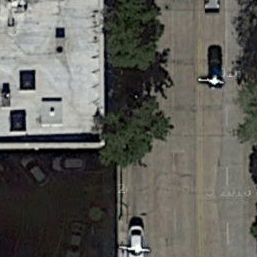

In [20]:
pDs.aerial_extractor.extract_image(dtecDF_Itrain.lat[0], dtecDF_Itrain.lng[0], 256, 256)

In [21]:
panoJson = pDs.streetview_extractor.get_nearest_pano(dtecDF_Itrain.lat[0], dtecDF_Itrain.lng[0])

time: 14.7 s (started: 2022-11-26 16:27:52 +00:00)
time: 156 ms (started: 2022-11-26 16:28:07 +00:00)


{'Data': {'copyright': '© 2016 Google',
  'tile_height': '512',
  'image_width': '13312',
  'image_height': '6656',
  'tile_width': '512',
  'imagery_type': 1,
  'image_date': '2015-06'},
 'Projection': {'pano_yaw_deg': '181.22',
  'tilt_yaw_deg': '69.18',
  'projection_type': 'spherical',
  'tilt_pitch_deg': '3.04'},
 'Links': [{'yawDeg': '0.16',
   'road_argb': '0x80fdf872',
   'description': 'N Arroyo Pkwy',
   'panoId': '4tCsw3eu4VWZtOCzqRwfzg'},
  {'yawDeg': '180.16',
   'road_argb': '0x80fdf872',
   'description': 'N Arroyo Pkwy',
   'panoId': 'BAbPNv-VpsC3U8DBe_N4fA'}],
 'Location': {'elevation_wgs84_m': '227.797870',
  'panoId': 'aAbBg_vCzltynugAdbU9ng',
  'description': 'N Arroyo Pkwy',
  'country': 'United States',
  'region': 'Pasadena, California',
  'elevation_egm96_m': '261.805298',
  'zoomLevels': '5',
  'original_lng': '-118.147713',
  'original_lat': '34.146575',
  'lat': '34.146643',
  'lng': '-118.147665'}}

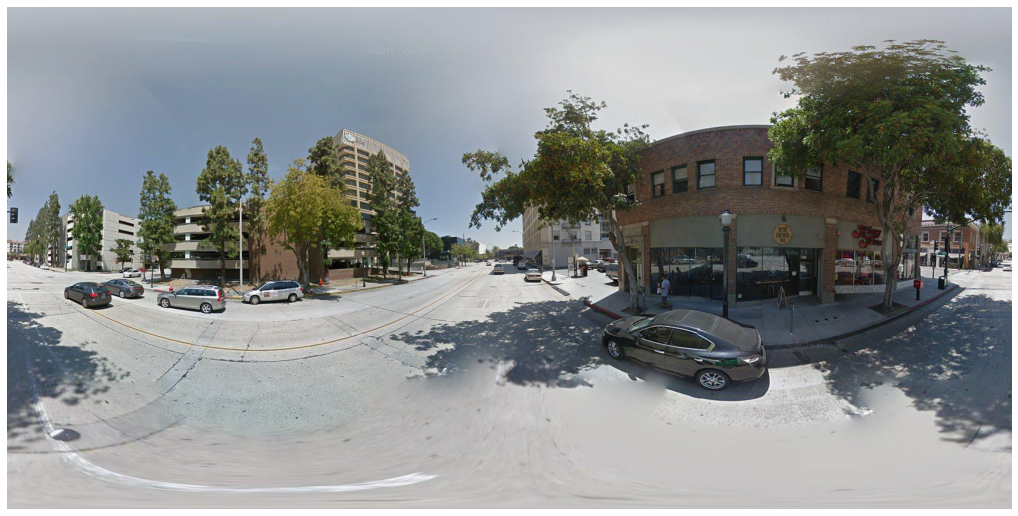

time: 1min 20s (started: 2022-11-26 16:30:12 +00:00)


In [23]:
pDs.streetview_extractor.get_nearest_pano(dtecDF_Itrain.lat[0], dtecDF_Itrain.lng[0], imgShow = 'out')

1371.8350137162922 - 294.3730414315718 - 1615.0889308531487 - 537.6269585684282


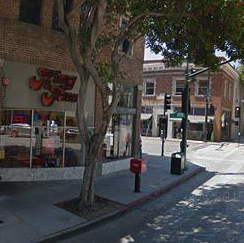

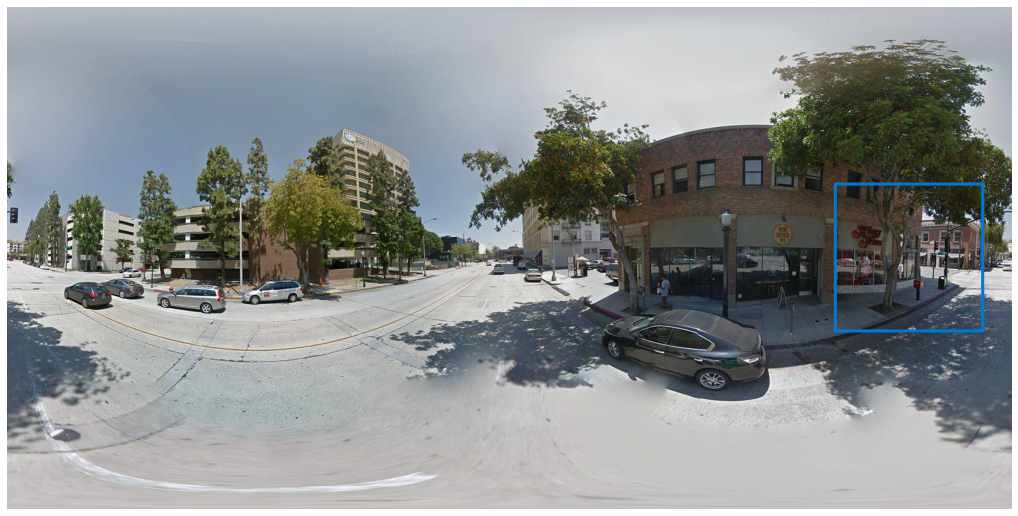

time: 958 ms (started: 2022-11-26 16:31:33 +00:00)


In [24]:
pDs.streetview_extractor.extract_image(pDs.streetview_extractor.get_nearest_pano(dtecDF_Itrain.lat[1], dtecDF_Itrain.lng[1]), 
                                       dtecDF_Itrain.lat[1], dtecDF_Itrain.lng[1], (8,8), height=-1,imgShow='out' )

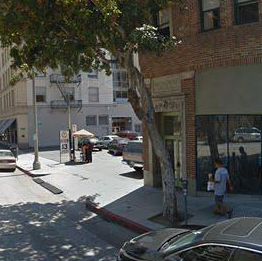

time: 274 ms (started: 2022-11-26 16:31:34 +00:00)


In [25]:
pDs.streetview_extractor.extract_image(pDs.streetview_extractor.get_nearest_pano(dtecDF_Itrain.lat[0], dtecDF_Itrain.lng[0]), dtecDF_Itrain.lat[0], dtecDF_Itrain.lng[0], (8,8), height=-1)

# Feature extract

In [26]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1+cu113 True
0.29.1
time: 7.3 ms (started: 2022-11-26 16:31:55 +00:00)


In [71]:
id = 1000
lat, lng = dtecDF_Itrain.lat[id], dtecDF_Itrain.lng[id]

time: 813 µs (started: 2022-11-26 16:59:34 +00:00)


## Result step by step

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

time: 998 µs (started: 2022-11-26 16:32:06 +00:00)


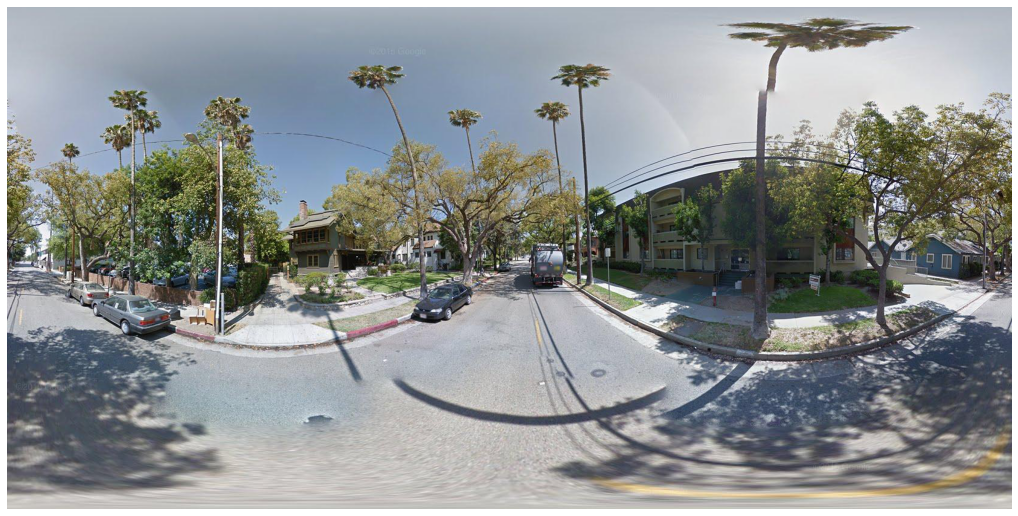

time: 747 ms (started: 2022-11-26 16:59:36 +00:00)


In [72]:
panoT = pDs.streetview_extractor.get_nearest_pano(lat, lng, imgShow = 'out')

In [73]:
panoT

{'Data': {'copyright': '© 2016 Google',
  'tile_height': '512',
  'image_width': '13312',
  'image_height': '6656',
  'tile_width': '512',
  'imagery_type': 1,
  'image_date': '2015-07'},
 'Projection': {'pano_yaw_deg': '353.05',
  'tilt_yaw_deg': '-101.11',
  'projection_type': 'spherical',
  'tilt_pitch_deg': '2.64'},
 'Links': [{'yawDeg': '179.14',
   'road_argb': '0x80fdf872',
   'description': 'N Catalina Ave',
   'panoId': 'NUN63dKDzFbGVGwskPiNcg'},
  {'yawDeg': '359.14',
   'road_argb': '0x80fdf872',
   'description': 'N Catalina Ave',
   'panoId': '2H2JFz2co_Fm43Gg5xWcpw'}],
 'Location': {'elevation_wgs84_m': '218.457840',
  'panoId': 'nqvo4wxT2KtiuHk0_qSVZg',
  'description': 'N Catalina Ave',
  'country': 'United States',
  'region': 'Pasadena, California',
  'elevation_egm96_m': '252.406235',
  'zoomLevels': '5',
  'original_lng': '-118.129434',
  'original_lat': '34.147133',
  'lat': '34.147129',
  'lng': '-118.129418'}}

time: 4.5 ms (started: 2022-11-26 16:59:37 +00:00)


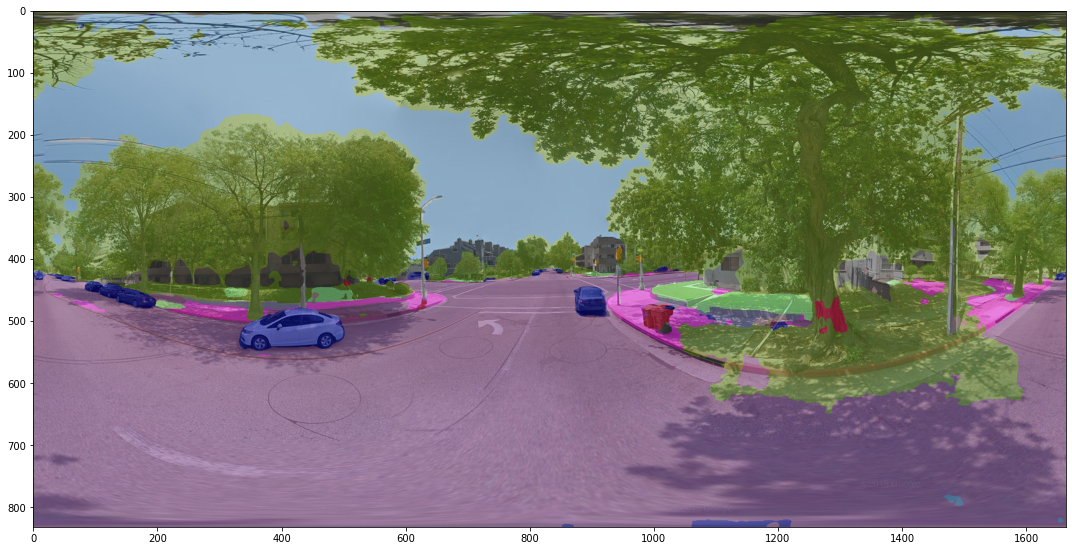

time: 1.79 s (started: 2022-11-26 16:58:57 +00:00)


In [70]:
# test a single image
imgT =  '/content/drive/MyDrive/Uni/Thesis/dataset/detection/PasadenaUrbanTrees/streetview/' + str(panoT['Location']['panoId']) + '_z2.jpg'
result = inference_segmentor(model, imgT)
# show the results
show_result_pyplot(model, imgT, result, get_palette('cityscapes'))

In [ ]:
### Color palette, and the 8 th class is for tree
get_palette('cityscapes')

[[128, 64, 128],
 [244, 35, 232],
 [70, 70, 70],
 [102, 102, 156],
 [190, 153, 153],
 [153, 153, 153],
 [250, 170, 30],
 [220, 220, 0],
 [107, 142, 35],
 [152, 251, 152],
 [70, 130, 180],
 [220, 20, 60],
 [255, 0, 0],
 [0, 0, 142],
 [0, 0, 70],
 [0, 60, 100],
 [0, 80, 100],
 [0, 0, 230],
 [119, 11, 32]]

time: 7.25 ms (started: 2022-11-21 02:56:47 +00:00)


In [ ]:
## process the to generate mask of tree only - class is 8 (consistence)
maskMap = (np.array(result)[0] == 8).astype(int)

time: 8.25 ms (started: 2022-11-21 01:58:34 +00:00)


In [ ]:
testImg = np.array((maskMap*255),dtype= 'u1')
grayImage = cv2.cvtColor(testImg, cv2.COLOR_GRAY2BGR)

time: 13.2 ms (started: 2022-11-21 01:58:36 +00:00)


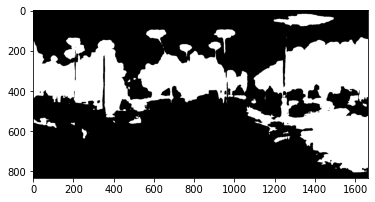

time: 528 ms (started: 2022-11-21 01:58:37 +00:00)


In [ ]:
plt.imshow(grayImage)

In [ ]:
#get threshold image
ret,thresh_img = cv2.threshold(grayImage, 1, 255, 0)
contours, hierarchy = cv2.findContours(maskMap.astype('u1'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

time: 10.8 ms (started: 2022-11-21 01:58:48 +00:00)


In [ ]:
len(contours)

66

time: 3.5 ms (started: 2022-11-21 01:58:49 +00:00)


(-0.5, 1663.5, 831.5, -0.5)

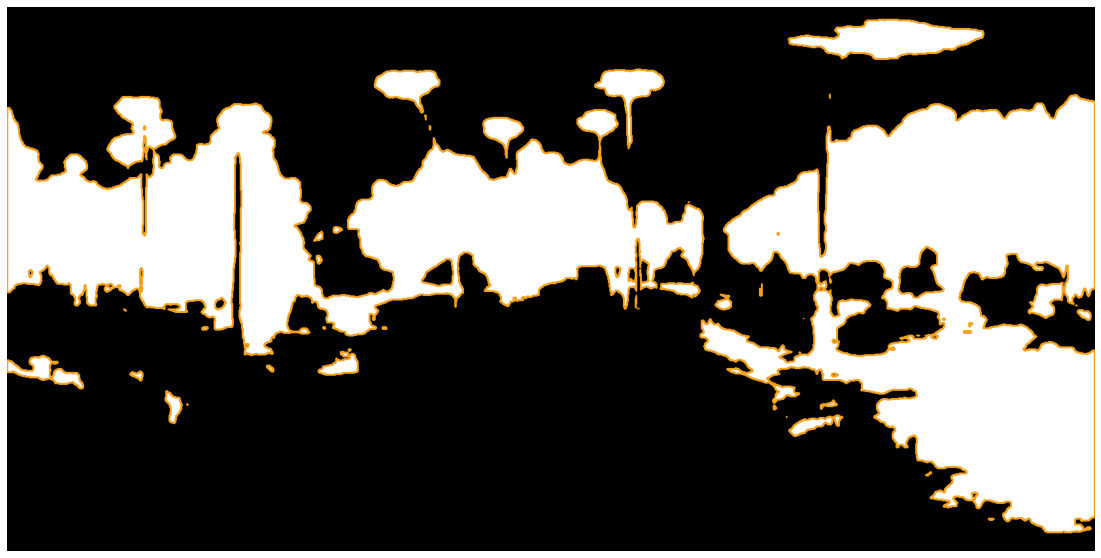

time: 422 ms (started: 2022-11-21 01:58:51 +00:00)


In [ ]:
for cnt in contours:
  img1 = cv2.drawContours(grayImage, [cnt], -1, (245,161,29), 2)


plt.figure(figsize = (20,10))
plt.imshow(grayImage, cmap='gray')
plt.axis('off')

In [ ]:
# This function allows us to create a descending sorted list of contour areas.
def contour_area(contours):
     
    # create an empty list
    cnt_area = []
     
    # loop through all the contours
    for i in range(0,len(contours),1):
        # for each contour, use OpenCV to calculate the area of the contour
        cnt_area.append(cv2.contourArea(contours[i]))
 
    # Sort our list of contour areas in descending order
    list.sort(cnt_area, reverse=True)
    return cnt_area

time: 1.15 ms (started: 2022-11-21 01:58:55 +00:00)


In [ ]:
def draw_bounding_box(contours, image, number_of_boxes=1):
    # Call our function to get the list of contour areas
    cnt_area = contour_area(contours)
    bndBoxes = []
    # Loop through each contour of our image
    for i in range(0,len(contours),1):
        cnt = contours[i]
 
        # Only draw the the largest number of boxes
        if (cv2.contourArea(cnt) > cnt_area[number_of_boxes]):
             
            # Use OpenCV boundingRect function to get the details of the contour
            x,y,w,h = cv2.boundingRect(cnt)
            bndBoxes.append(np.array([x, y, x+w, y+h]))
            # Draw the bounding box
            image=cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
 
    return image, bndBoxes

time: 3.04 ms (started: 2022-11-21 01:58:59 +00:00)


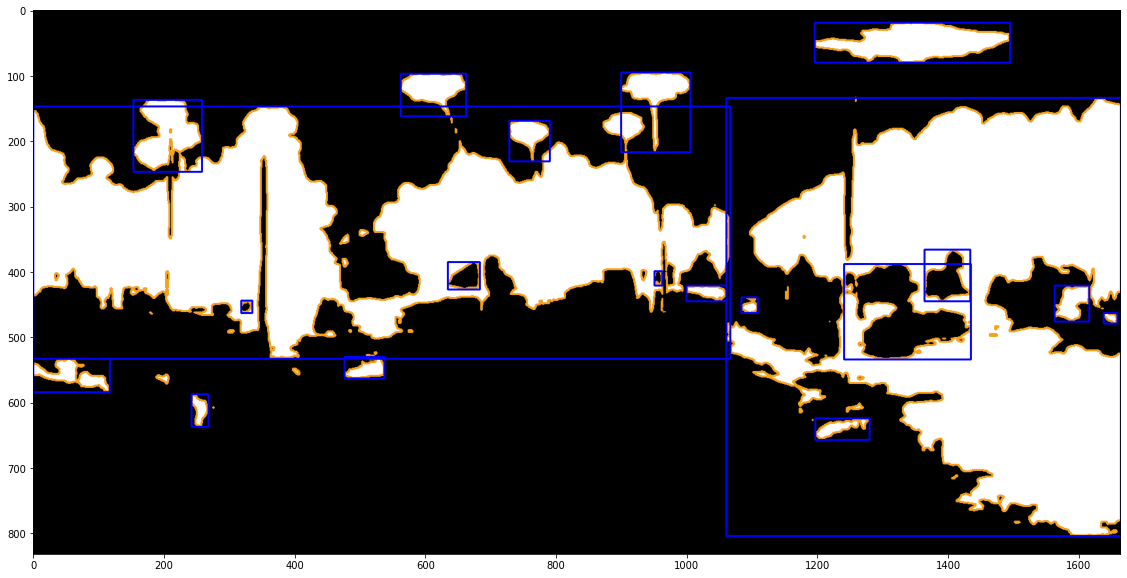

time: 525 ms (started: 2022-11-21 01:59:02 +00:00)


In [ ]:
treeThresh = len(contours) - 1 if len(contours) < 20 else 20
boxImg, bndBoxes = draw_bounding_box(contours, grayImage, treeThresh)
plt.figure(figsize = (20,10))
plt.imshow(boxImg, cmap='gray')
# plt.axis('off')

In [ ]:
pxl_pt=  pDs.streetview_extractor.geo_coords_to_streetview_pixel(panoT, lat, lng)
pxl_pt

(608.0794925806313, 542.8806846067151)

time: 3.83 ms (started: 2022-11-21 02:34:21 +00:00)


In [ ]:
# Sort bounding box to prepared for the binary search of center pixel
bndBoxes = np.array(bndBoxes)
bndBoxes = bndBoxes[bndBoxes[:, 0].argsort()]
bndBoxes = bndBoxes[bndBoxes[:,1] < 626] ## 626 is street threshold
bndBoxes

array([[   0,  147, 1066,  533],
       [   0,  533,  117,  584],
       [ 153,  137,  258,  247],
       [ 242,  587,  268,  637],
       [ 318,  444,  335,  463],
       [ 476,  530,  537,  563],
       [ 562,   97,  662,  162],
       [ 634,  385,  683,  427],
       [ 728,  169,  790,  231],
       [ 899,   95, 1005,  217],
       [ 950,  399,  962,  421],
       [ 999,  421, 1060,  445],
       [1060,  134, 1664,  804],
       [1083,  439, 1108,  463],
       [1195,   19, 1494,   80],
       [1196,  624, 1279,  657],
       [1240,  388, 1434,  534],
       [1363,  366, 1433,  445],
       [1562,  421, 1615,  476],
       [1637,  463, 1658,  479]])

time: 8.12 ms (started: 2022-11-21 02:35:04 +00:00)


In [ ]:
def bSearch(arr, low, high, x):
    """
    arr: array of pixel x of top left corners
    low: lower pointer (index)
    high: higher pointer (index)
    x: insert value for comparision
    -------------------------------
    RETURN the index that x just abit larger than arr[index].
    """
    if arr[low] > x:
      return -1
    
    if arr[high] < x:
      return high

    if high >= low:

        mid = (high + low) // 2

        if arr[mid] == x or (x < arr[mid+1] and x > arr[mid]):
            return mid
        
        elif arr[mid] > x:
            return bSearch(arr, low, mid-1, x)

        elif arr[mid] < x:
            return bSearch(arr, mid+1, high, x)

    else:
        return -1
    

time: 1.73 ms (started: 2022-11-21 01:59:40 +00:00)


In [ ]:
def find_potential_bbox(bbArr, pixel, direction='v'):
    """
    bbArr (np.ndarray):  array of bounding box
    pixel (any format): pixel coordination - x: row, y:col
    direction (str): first sorted array base; either 'h' - horizontal for y OR 'v' vertical for the x
    ------------------------------------------------------
    RETURN: array of potential bounding boxes.
    """
    # Sort bounding box to prepared for the binary search of center pixel
    
    
    bbArr = bbArr[bbArr[:, 0].argsort()] if direction == 'v' else bbArr[bbArr[:, 1].argsort()]

    idx = bSearch(bbArr[:,0], 0,len(bbArr)-1, pixel[0]) if direction == 'v' else bSearch(bbArr[:,1], 0,len(bbArr)-1, pixel[1]) 

    if idx >= len(bbArr) - 2:
        return bbArr
    
    elif idx == -1:
        return np.empty(0)
    
    else:
        return bbArr[0:idx+2]

    return np.empty(0)

time: 2.11 ms (started: 2022-11-21 01:59:43 +00:00)


In [ ]:
find_potential_bbox(bndBoxes,pxl_pt)

array([[   0,  147, 1066,  533],
       [   0,  533,  117,  584],
       [ 153,  137,  258,  247],
       [ 242,  587,  268,  637],
       [ 318,  444,  335,  463],
       [ 476,  530,  537,  563],
       [ 562,   97,  662,  162],
       [ 634,  385,  683,  427]])

time: 4.29 ms (started: 2022-11-21 02:36:08 +00:00)


In [ ]:
def isInside(obj, box):
    """
    obj: pixel location of tree (x, y)
    box: bounding box - 2 pixel points of top left and bottom right corners (x1,y1,x2,y2)
    """

    oX, oY = obj
    tX, tY, bX, bY = box 

    x_inRange = oX >= tX and oX <= bX
    y_inRange = oY >= tY and oY <= bY

    return x_inRange and y_inRange

time: 1.26 ms (started: 2022-11-21 02:36:11 +00:00)


In [ ]:
def find_closest_bb(bbArr, pxl):
    return 0

time: 690 µs (started: 2022-11-21 02:36:14 +00:00)


In [ ]:
def on_street(bbArr):
    street_thresh = 626 #The image w is 832, and 25% of it is street => 75% remain is potentially tree/ terrian
    if nnArr[1] > street_thresh:
        return True
    
    return False

time: 1.07 ms (started: 2022-11-21 02:36:17 +00:00)


In [ ]:
def find_bbox(bbArr, pixel):
    """
    bbArr (np.ndarray):  array of bounding box
    pixel (any format): pixel coordination - x_: col, y|:row
    ------------------------------------------------------
    RETURN: list of bounding boxes that the pixel points laid/ close to inside.
    """  
    bbArr = np.array(bbArr) #covert to np array, incase
    potentialArr = find_potential_bbox(bbArr,pixel)
    bbList = []

    if len(potentialArr) != 0:
        for bb in potentialArr:
            x1,y1, x2, y2 = bb
            
            if isInside(pixel,(x1,y1,x2,y2)):
                bbList.append(bb)
    print(f'bbList: {bbList}')
    print(f'potentialArr: {len(potentialArr)}')
    print(f'NEXT Condition: {len(bbList) == 0 and len(potentialArr) != 0}')
    
      ## Adding bbox that closet to the pixel, incase the pxl pt is outside the box
    if len(bbList) == 0 and len(potentialArr) != 0:
        print("in")
        bbList.extend(find_potential_bbox(bbArr,pixel)[-2:])
        bbList.extend(find_potential_bbox(bbArr,pixel,'h')[-2:])
    
    return bbList

time: 3.15 ms (started: 2022-11-21 02:40:50 +00:00)


In [ ]:
def pxHeight_extract(bboxes):
    hList = []
    
    for b in bboxes:
        hList.append([b[3]-b[1],b])
    
    hArr = np.array(hList)
    return hArr[hArr[:,0].argsort()]

time: 1.43 ms (started: 2022-11-21 02:40:52 +00:00)


In [ ]:
#Testing
coveredBoxes = find_bbox(bndBoxes,pxl_pt)
coveredBoxes

bbList: []
potentialArr: 8
NEXT Condition: True
in


[array([562,  97, 662, 162]),
 array([634, 385, 683, 427]),
 array([  0, 533, 117, 584]),
 array([242, 587, 268, 637])]

time: 8.12 ms (started: 2022-11-21 02:40:54 +00:00)


In [ ]:
type(coveredBoxes)

list

time: 3.1 ms (started: 2022-11-21 02:45:59 +00:00)


In [ ]:
pxHeight_extract(coveredBoxes)[0][0]

42

time: 4.49 ms (started: 2022-11-21 02:44:18 +00:00)


## Mock test on data

In [ ]:
## Function added to the image_extract.py file

pxl_h = pDs.streetview_extractor.pixel_height(pDs.streetview_extractor.get_nearest_pano(lat, lng),lat,lng)

<class 'list'>
[[609 array([   0,    8, 1664,  617])]]
time: 1.25 s (started: 2022-11-21 02:50:52 +00:00)


In [ ]:
pxl_h

42

time: 3.92 ms (started: 2022-11-21 02:50:28 +00:00)


In [ ]:
h = pDs.streetview_extractor.pixel_height_to_physical_height(pDs.streetview_extractor.get_nearest_pano(lat, lng), lat, lng, 300)

print(f'The height of tree is {h:.2f} meters')

The height of tree is 28.39 meters
time: 127 ms (started: 2022-11-21 02:51:45 +00:00)
